In [1]:
import torch
import torchvision
from torch import nn
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime

In [2]:
model = Perceiver(
    input_channels = 1,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    freq_base = 2,
    depth = 6,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 16,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 32,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 2,            # number of heads for latent self attention, 8
    cross_dim_head = 4,         # number of dimensions per cross attention head
    latent_dim_head = 4,        # number of dimensions per latent self attention head
    num_classes = 10, # 91,          # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

# img = torch.randn(1, 28, 28, 1) # 1 imagenet image, pixelized

# model(img).shape # (1, 1000)
model_name = 'baseline_mnist'
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

68710
68710


In [3]:
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

68710
68710


In [4]:
# imagenet_data = torchvision.datasets.ImageNet('/home/gabriel/Documents/datasets/')
# data_loader = torch.utils.data.DataLoader(imagenet_data,
#                                           batch_size=32,
#                                           shuffle=True,
#                                           num_workers=20)
# train_loader, val_loader, test_loader

In [5]:
torch.manual_seed(0)

batch_size = 16

mnist_train = torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True, num_workers=10)

/home/gabriel/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# class CocoMultilabelDataset(torch.utils.data.Dataset):
#     def __init__(self, coco_dataset):
#         self.coco_dataset = coco_dataset
        
#     def __getitem__(self, index):
#         target = torch.zeros((91,))
#         for det in self.coco_dataset[index][1]:
#             if det['category_id'] > 90:
#                 print(det)
#             target[det['category_id']] = 1
#         return (self.coco_dataset[index][0], target)
    
#     def __len__(self):
#         return len(self.coco_dataset)

# torch.manual_seed(0)
# batch_size = 16
# coco_train = torchvision.datasets.CocoDetection(root = '/home/gabriel/Documents/datasets/COCO/train2017',
#                                                 annFile = '/home/gabriel/Documents/datasets/COCO/annotations/instances_train2017.json',
#                                                 transform=torchvision.transforms.Compose([
#                                                     torchvision.transforms.Resize((112, 112)),
#                                                     torchvision.transforms.ToTensor(), + 20
#                                                     torchvision.transforms.Normalize(
#                                                         (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                                 ]))
# coco_train = CocoMultilabelDataset(coco_train)
# split = int(0.9 * len(coco_train))
# train_set, val_set = torch.utils.data.random_split(coco_train, [split, len(coco_train) - split])
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10)
# test_set = torchvision.datasets.CocoDetection(root = '/home/gabriel/Documents/datasets/COCO/val2017',
#                                               annFile = '/home/gabriel/Documents/datasets/COCO/annotations/instances_val2017.json',
#                                               transform=torchvision.transforms.Compose([
#                                                   torchvision.transforms.Resize((112, 112)),
#                                                   torchvision.transforms.ToTensor(),
#                                                   torchvision.transforms.Normalize(
#                                                       (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                               ]))
# test_set = CocoMultilabelDataset(test_set)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=10)

# print(len(coco_train))
# im = torch.transpose(torch.transpose(coco_train[1][0], 0, 1), 1, 2)
# plt.imshow(im.cpu().numpy())
# plt.show()

In [7]:
# torch.manual_seed(0)
# batch_size = 16

# train_set = torchvision.datasets.CelebA(root = '/home/gabriel/Documents/datasets/CelebA/Img/img_celeba.7z', split='train',
#                                         transform=torchvision.transforms.Compose([
#                                            torchvision.transforms.Resize((112, 112)),
#                                            torchvision.transforms.ToTensor(),
#                                            torchvision.transforms.Normalize(
#                                                (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                        ]))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
# val_set = torchvision.datasets.CelebA(root = '/home/gabriel/Documents/datasets/CelebA', split='valid',
#                                       transform=torchvision.transforms.Compose([
#                                           torchvision.transforms.Resize((112, 112)),
#                                           torchvision.transforms.ToTensor(),
#                                           torchvision.transforms.Normalize(
#                                             (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                       ]))
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10)
# test_set = torchvision.datasets.CelebA(root = '/home/gabriel/Documents/datasets/CelebA', split='test',
#                                        transform=torchvision.transforms.Compose([
#                                            torchvision.transforms.Resize((112, 112)),
#                                            torchvision.transforms.ToTensor(),
#                                            torchvision.transforms.Normalize(
#                                                (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                        ]))
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=10)


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

max_epochs = 40

# checkpoint = torch.load(f'checkpoints/{model_name}/best_checkpoint.pt')
# model.load_state_dict(checkpoint['state_dict'])
model.to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = 100000.0

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')

now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")
    
for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    loss_sum = 0
    loss_count = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
#         from matplotlib import pyplot as plt
#         plt.imshow(X_batch[0].cpu().numpy())
#         plt.show()
#         print(X_batch.shape, y_batch.shape)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        writer.add_scalars("losses_step", {"train_loss": loss.data}, epoch * len(train_loader) + batch_idx)
        
    model.eval()
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.data

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * len(train_loader) - 1)
    
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

cuda:0


Epoch 1/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.910584 	Validation Loss: 1.252806
Validation loss decreased (100000.000000 --> 1.252806).  Saving model ...


Epoch 2/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.030035 	Validation Loss: 0.869505
Validation loss decreased (1.252806 --> 0.869505).  Saving model ...


Epoch 3/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.727002 	Validation Loss: 0.643767
Validation loss decreased (0.869505 --> 0.643767).  Saving model ...


Epoch 4/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.559211 	Validation Loss: 0.490646
Validation loss decreased (0.643767 --> 0.490646).  Saving model ...


Epoch 5/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.458884 	Validation Loss: 0.428644
Validation loss decreased (0.490646 --> 0.428644).  Saving model ...


Epoch 6/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.398079 	Validation Loss: 0.382722
Validation loss decreased (0.428644 --> 0.382722).  Saving model ...


Epoch 7/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.355279 	Validation Loss: 0.348390
Validation loss decreased (0.382722 --> 0.348390).  Saving model ...


Epoch 8/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.325809 	Validation Loss: 0.280980
Validation loss decreased (0.348390 --> 0.280980).  Saving model ...


Epoch 9/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.291823 	Validation Loss: 0.277409
Validation loss decreased (0.280980 --> 0.277409).  Saving model ...


Epoch 10/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.264451 	Validation Loss: 0.309764


Epoch 11/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.243042 	Validation Loss: 0.229609
Validation loss decreased (0.277409 --> 0.229609).  Saving model ...


Epoch 12/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.224481 	Validation Loss: 0.234013


Epoch 13/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.207202 	Validation Loss: 0.220822
Validation loss decreased (0.229609 --> 0.220822).  Saving model ...


Epoch 14/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.194905 	Validation Loss: 0.220088
Validation loss decreased (0.220822 --> 0.220088).  Saving model ...


Epoch 15/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.181285 	Validation Loss: 0.188697
Validation loss decreased (0.220088 --> 0.188697).  Saving model ...


Epoch 16/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.169566 	Validation Loss: 0.185279
Validation loss decreased (0.188697 --> 0.185279).  Saving model ...


Epoch 17/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.160201 	Validation Loss: 0.178227
Validation loss decreased (0.185279 --> 0.178227).  Saving model ...


Epoch 18/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.151813 	Validation Loss: 0.173717
Validation loss decreased (0.178227 --> 0.173717).  Saving model ...


Epoch 19/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.143809 	Validation Loss: 0.155446
Validation loss decreased (0.173717 --> 0.155446).  Saving model ...


Epoch 20/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.136767 	Validation Loss: 0.156324


Epoch 21/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.129524 	Validation Loss: 0.178124


Epoch 22/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.124061 	Validation Loss: 0.147683
Validation loss decreased (0.155446 --> 0.147683).  Saving model ...


Epoch 23/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.117953 	Validation Loss: 0.149561


Epoch 24/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.112317 	Validation Loss: 0.140744
Validation loss decreased (0.147683 --> 0.140744).  Saving model ...


Epoch 25/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.107560 	Validation Loss: 0.133963
Validation loss decreased (0.140744 --> 0.133963).  Saving model ...


Epoch 26/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.103582 	Validation Loss: 0.144720


Epoch 27/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.099946 	Validation Loss: 0.134149


Epoch 28/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.095703 	Validation Loss: 0.134288


Epoch 29/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.091806 	Validation Loss: 0.149976


Epoch 30/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.088766 	Validation Loss: 0.137566


Epoch 31/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.085816 	Validation Loss: 0.138189


Epoch 32/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.080665 	Validation Loss: 0.167012


Epoch 33/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.078650 	Validation Loss: 0.120623
Validation loss decreased (0.133963 --> 0.120623).  Saving model ...


Epoch 34/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.075343 	Validation Loss: 0.134766


Epoch 35/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.071641 	Validation Loss: 0.143141


Epoch 36/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.069591 	Validation Loss: 0.132693


Epoch 37/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.067059 	Validation Loss: 0.124254


Epoch 38/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.064065 	Validation Loss: 0.124921


Epoch 39/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.062341 	Validation Loss: 0.118038
Validation loss decreased (0.120623 --> 0.118038).  Saving model ...


Epoch 40/40:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.058473 	Validation Loss: 0.127084


In [9]:
def multilabel_acc(y_pred, y_true):
    correct = 0
    total = 0
    for i in tqdm(range(len(y_true)), desc=f"Computing accuracy"):
        pred = y_pred[i]
        true = y_true[i]
        for j in range(len(true)):
            total += 1
            if true[j] == round(float(pred[j])):
                correct += 1
                
    return correct / total


# def multilabel_prec(y_pred, y_true):
#     correct = 0
#     total = 0
#     for i in tqdm(range(len(y_true)), desc=f"Computing precision"):
#         pred = y_pred[i]
#         true = y_true[i]
#         for j in range(len(true)):
#             total += 1
#             if true[j] == 1:
#                 if round(float(pred[j])) == 1:
#                     correct += 1
#             elif round(float(pred[j])) == 0:
#                 correct += 1
                
#     return correct / total


# def multilabel_recall(y_pred, y_true):
#     correct = 0
#     total = 0
#     for i in tqdm(range(len(y_true)), desc=f"Computing recall"):
#         pred = y_pred[i]
#         true = y_true[i]
#         for j in range(len(true)):
#             total += 1
#             if true[j] == 1:
#                 if round(float(pred[j])) == 1:
#                     correct += 1
#             elif round(float(pred[j])) == 0:
#                 correct += 1
                
#     return correct / total

Inference:   0%|          | 0/625 [00:00<?, ?it/s]

0.9633
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.94      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.94      0.96      0.95       892
           6       0.99      0.95      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 432x288 with 0 Axes>

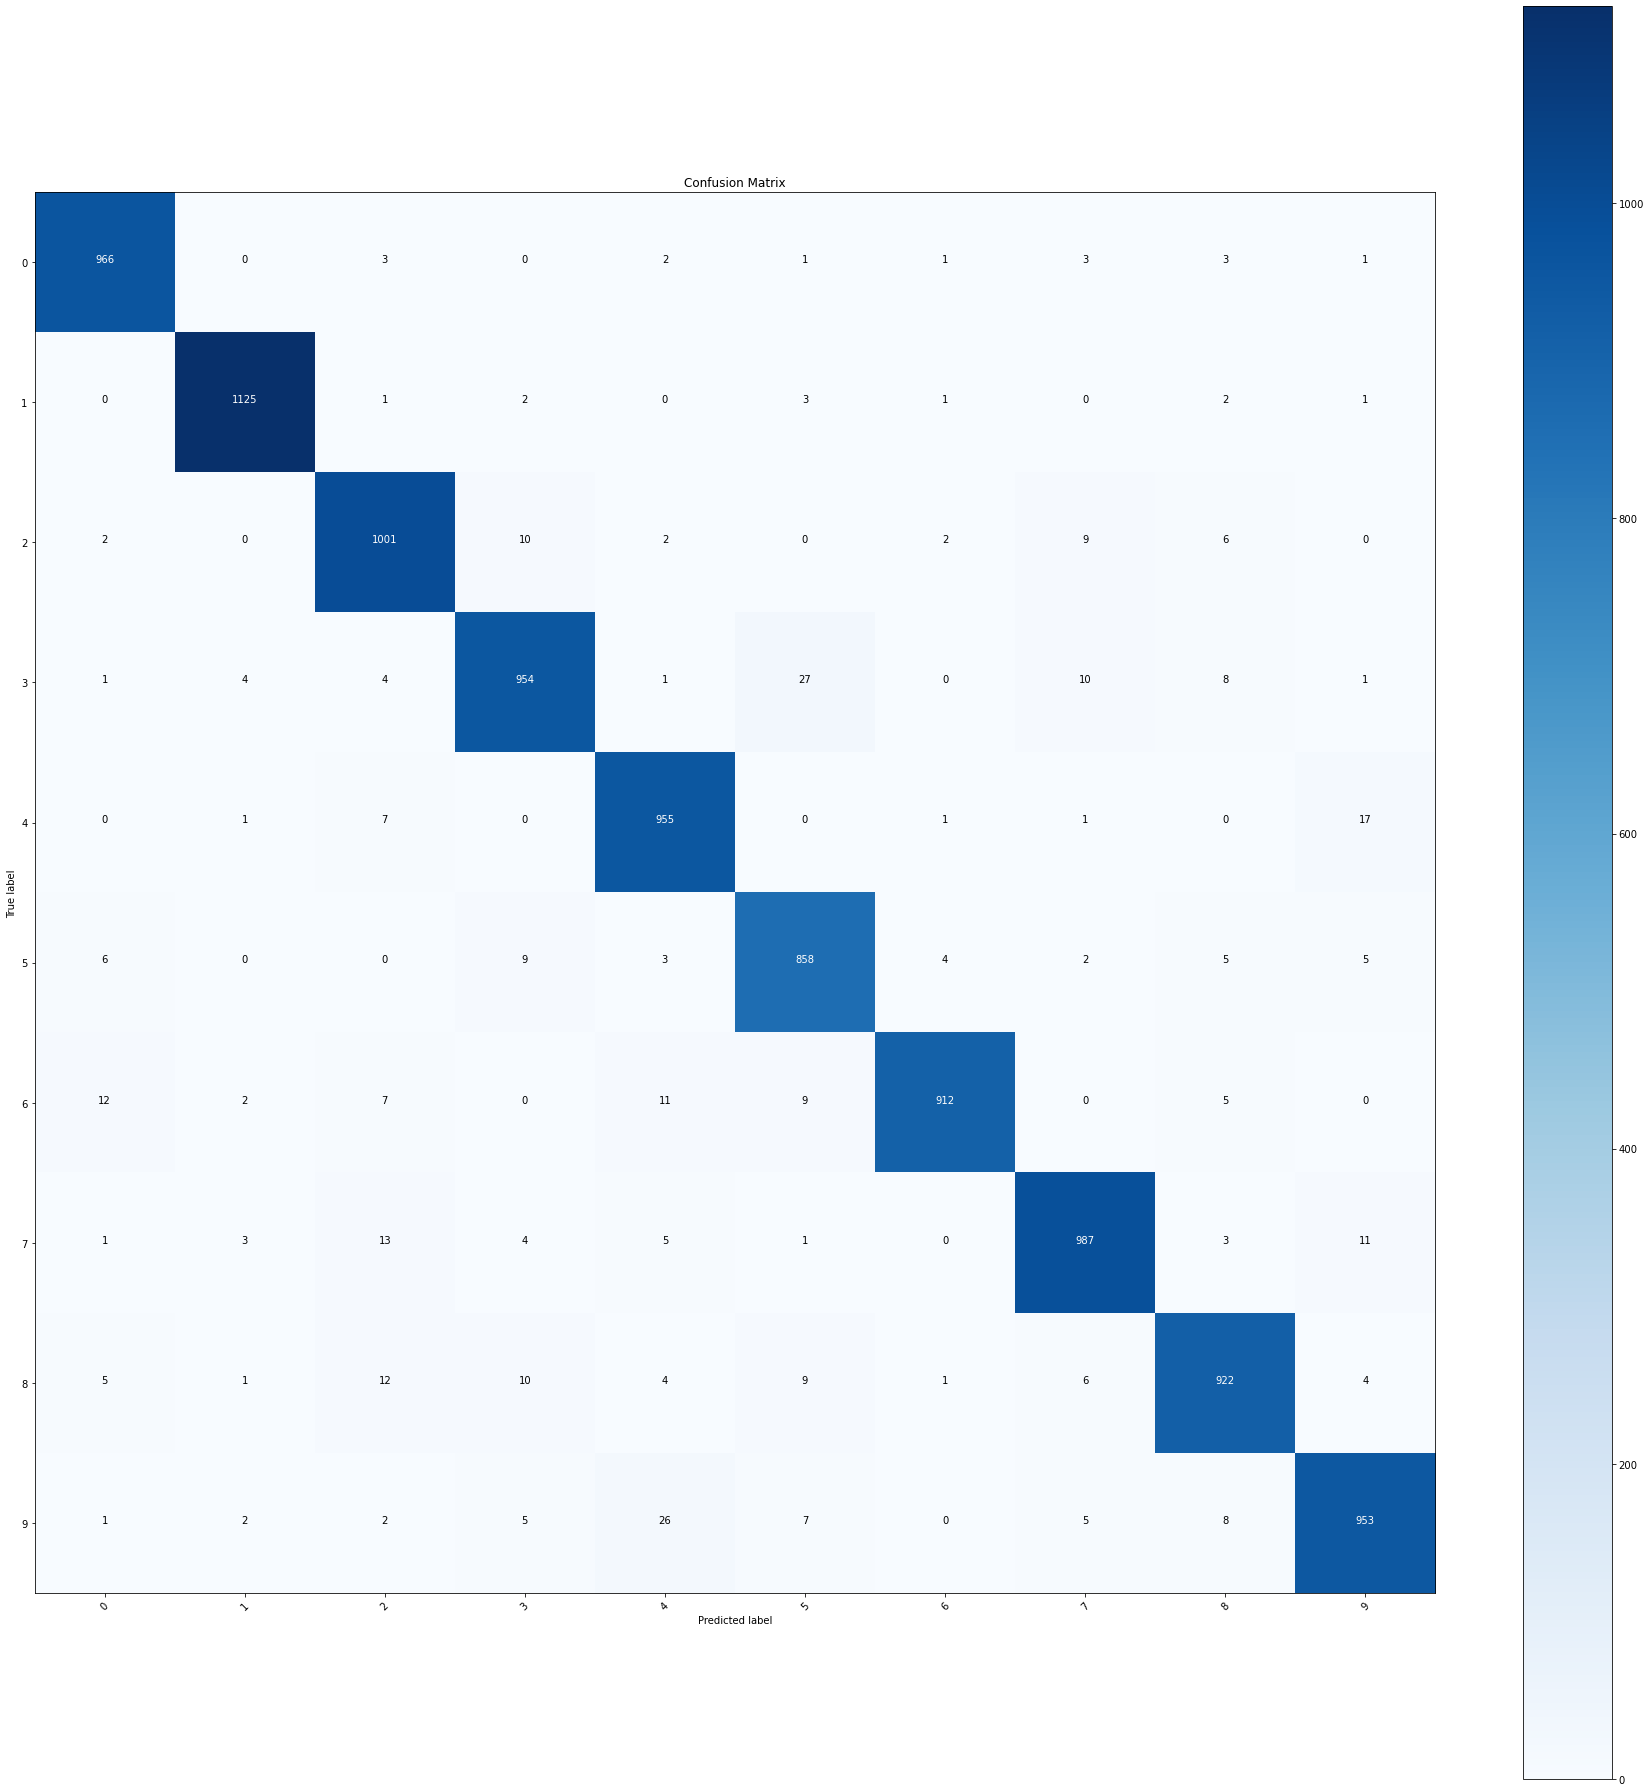

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)
# checkpoint = torch.load(f'checkpoints/{model_name}/best_checkpoint.pt')
# model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)
# m = nn.Sigmoid()
y_pred_extended = []
y_true_extended = []
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(test_loader, desc=f"Inference")):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
        y_pred = model(X_batch).cpu()
        y_pred = m(y_pred)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_batch.cpu())
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# single label
accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in list(range(10))], title = ('Confusion Matrix'))
plt.show()

# # multilabel
# accuracy = multilabel_acc(y_pred_extended, y_true_extended)
# # precision = multilabel_prec(y_pred_extended, y_true_extended)
# # recall = multilabel_recall(y_pred_extended, y_true_extended)
# print(accuracy)  # , precision, recall)

In [11]:
# model = Perceiver(
#     input_channels = 3,          # number of channels for each token of the input
#     input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
#     num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
#     max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
#     freq_base = 2,
#     depth = 2,                   # depth of net. The shape of the final attention mechanism will be:
#                                  #   depth * (cross attention -> self_per_cross_attn * self attention)
#     num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
#     latent_dim = 256,            # latent dimension
#     cross_heads = 1,             # number of heads for cross attention. paper said 1
#     latent_heads = 2,            # number of heads for latent self attention, 8
#     cross_dim_head = 32,         # number of dimensions per cross attention head
#     latent_dim_head = 32,        # number of dimensions per latent self attention head
#     num_classes = 1000,          # output number of classes
#     attn_dropout = 0.,
#     ff_dropout = 0.,
#     weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
#     fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
#     self_per_cross_attn = 2      # number of self attention blocks per cross attention
# )

# print(len(model.layers))

In [12]:
# model.layers.append(model.layers[1])
# print(len(model.layers))